In [1]:
import numpy.linalg as ln
import os
import numpy as np
import scipy.signal
import pandas as pd
from pandas.core.resample import Resampler
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

# Load MouthShape
- Load mouth-shape matrix
- Normalize the mouth-shape with zero center
- Up-sample the mouth-shape

In [2]:
def load_mouthshape(filename='Train/mouthTrain.txt', nFramesUpsampled = 1848000):
    filename = os.path.abspath(filename)
    file =  open(filename, "r")
    lines = file.readlines()
    nums = [ x.split() for x in lines ]
    mouthShape = np.array([ [ int(x)  for x in array   ]  for array in nums ])
    
    # Normalize the mouth shape
    n,d = mouthShape.shape
    mouthShapeNorm = []
    for i in range(n):
        xs = [mouthShape[i][k] for k in range(0,len(mouthShape[i]),2) ]
        meanX = np.mean(xs)
        ys = [mouthShape[i][k] for k in range(1,len(mouthShape[i]),2) ]
        meanY = np.mean(ys)

        difx = xs[0] - meanX
        dify = ys[0] - meanY
        dist = np.sqrt(difx*difx + dify*dify)
        
        xs = [x - meanX for x in xs]
        ys = [y - meanY for y in ys]
        meanShape = []
        for j in range(len(mouthShape[i])//2):
            meanShape += [xs[j]/dist,ys[j]/dist]
        mouthShapeNorm += [meanShape]

    mouthShape = mouthShapeNorm
    mouthShape = np.array(mouthShape)    
    
    # Upsample
    idxs1  = np.arange(0, mouthShape.shape[0])
    idxs2 = np.linspace(0, nFramesUpsampled, num=mouthShape.shape[0], endpoint=False, dtype='int64')
    upsampled = np.empty((nFramesUpsampled, mouthShape.shape[1]))
    upsampled[:] = np.nan
    upsampled[idxs2] = mouthShape[idxs1]
    df = pd.DataFrame(data=upsampled)
    df = df.interpolate(method='linear')
    mouthShapeResampled = df.values
    
    return mouthShapeResampled

Now `mouthShape` has is an array storing the coordinates of the points describing the mouth shape, in the following format:

| Frame id | X[row][0] | X[row][1] | X[row][2] | X[row][3] |
|----------|------|------|------|------|
| Frame 0  | x(0) | y(0) | x(1) | y(1) |
| Frame 1  | x(0) | y(0) | x(1) | y(1) |

In [3]:
mouthShapeResampled = load_mouthshape()
print(mouthShapeResampled.shape)

(1848000, 36)


# Load PCA matrix
- Load PCA matrix
- Up-sample PCA matrix

In [4]:
def load_PCA(filename='Train/pcaTrain.txt', nFramesUpsampled = 1848000, train=False):
    filename = os.path.abspath(filename)
    lines = [line.rstrip('\n') for line in open(filename, "r")]
    elements = [] # list of lists of strings of numbers
    lines = lines[1:]
    for line in lines:
        elements += [line.split(' ')[1:]]
    
    pca = np.array([[float(x) for x in line] for line in elements])

    if not train:
        return pca
    
    # Upsample
    idxs1  = np.arange(0, pca.shape[0])
    idxs2 = np.linspace(0, nFramesUpsampled, num=pca.shape[0], endpoint=False, dtype='int64')
    upsampled = np.empty((nFramesUpsampled, pca.shape[1]))
    upsampled[:] = np.nan
    upsampled[idxs2] = pca[idxs1]
    df = pd.DataFrame(data=upsampled)
    df = df.interpolate(method='linear')
    pcaResampled = df.values
    
    return pcaResampled

In [5]:
pcaResampled = load_PCA(train=True)
print(pcaResampled.shape)

(1848000, 20)


# Matrix Inversion

In [6]:
pcaInv = ln.pinv(pcaResampled)
transformationMatrix = pcaInv @ mouthShapeResampled
print(transformationMatrix.shape)

(20, 36)


# Test on original video

### Load PCA and Mouth Data

In [7]:
def loadData(pcaPath, mouthPath, matrix):

    #we compute mouthShape data using our matrix
    pcaEval = load_PCA(filename=pcaPath, train=False)
    transformedPCA = pcaEval @ matrix
    X = np.array(transformedPCA)
    
    
    
    #Load original mouthshape data
    mouthShapeResampled = load_mouthshape(filename=mouthPath)
    subsampled_idxs = np.linspace(0, mouthShapeResampled.shape[0], num=X.shape[0], endpoint=False, dtype='int64')
    Y = mouthShapeResampled[subsampled_idxs]
    
    assert X.shape == Y.shape
    n,d = X.shape
    
    return n,d,X,Y



In [8]:
n,d,X,Y = loadData("Train/pcaTrain.txt","Train/mouthTrain.txt",transformationMatrix)

## Visualization

In [9]:
#Number of frames we use to make the animation
testNFrames = 36960

In [10]:
def find_limits(X, Y):
    def find_limit(A):
        x_min = np.inf
        x_max = -np.inf
        y_min = np.inf
        y_max = -np.inf
        for row in range(A.shape[0]):
            for col in range(A.shape[1]):
                if col % 2 == 0:
                    x_min = min(x_min, A[row][col])
                    x_max = max(x_max, A[row][col])
                else:
                    y_min = min(y_min, A[row][col])
                    y_max = max(y_max, A[row][col])
        return (x_min, x_max), (y_min, y_max)
        
    (lim_x1, lim_y1) = find_limit(X)
    (lim_x2, lim_y2) = find_limit(Y)
    return (min(lim_x1[0],lim_x2[0]), max(lim_x1[1],lim_x2[1])), \
           (min(lim_y1[0],lim_y2[0]), max(lim_y1[1],lim_y2[1]))

In [11]:
def frameSetup():
    global X,Y
    
    fig = plt.figure(figsize=(12,8))
    (xlim, ylim) = find_limits(X, Y)
    ax = plt.axes(xlim=xlim, ylim=ylim)

    # Placeholder for 2 animations
    plots = [plt.plot([], [], 'bo', alpha=0.5, label='PCA (generated)')[0], 
             plt.plot([], [], 'ro', alpha=0.5, label='Actual')[0]]

    for i in range(d//2):
        plots.append(plt.plot([], [], 'g-', alpha=0.8)[0])

    legends = [ax.legend(loc=2)]
    
    return fig, plots, legends

def get_coords(X, frame, dim):
    x_coords = []
    y_coords = []
    for k in range(0, dim//2):
        x_coords.append(X[frame][2*k])
        y_coords.append(X[frame][2*(k)+1])
    return x_coords, y_coords

def init():
    for plot in plots:
        plot.set_data([], [])
    return plots

def animate(frameIdx):
    global X, Y
    
    x_coords1, y_coords1 = get_coords(X, frameIdx, d)
    plots[0].set_data(x_coords1, y_coords1)
    legends[0].texts[0].set_text('PCA (generated)')
    
    x_coords2, y_coords2 = get_coords(Y, frameIdx, d)
    plots[1].set_data(x_coords2, y_coords2)
    legends[0].texts[1].set_text('Actual')
    
    for i in range(d//2):
        plots[2+i].set_data([(x_coords1[i], x_coords2[i])], [(y_coords1[i], y_coords2[i])])
    
    return plots + legends



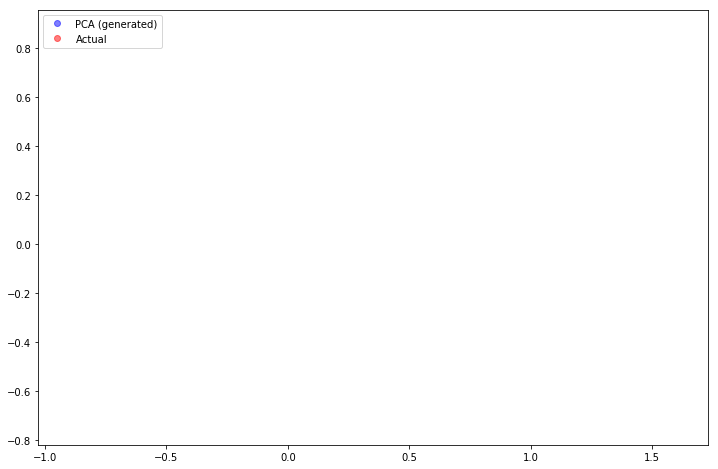

In [12]:
fig,plots,legends = frameSetup()
anim = FuncAnimation(fig, animate, init_func=init, frames=1000, interval=30)

In [13]:
print(len(plots))

20


In [14]:
HTML(anim.to_html5_video())

# Evaluate on English Video (From an Obama Speech)

In [15]:
n,d,X,Y = loadData("Eval/pcaEval1.txt","Eval/mouthEval1.txt",transformationMatrix)

In [16]:
#Number of frames we use to make the animation
testNFrames = 36960

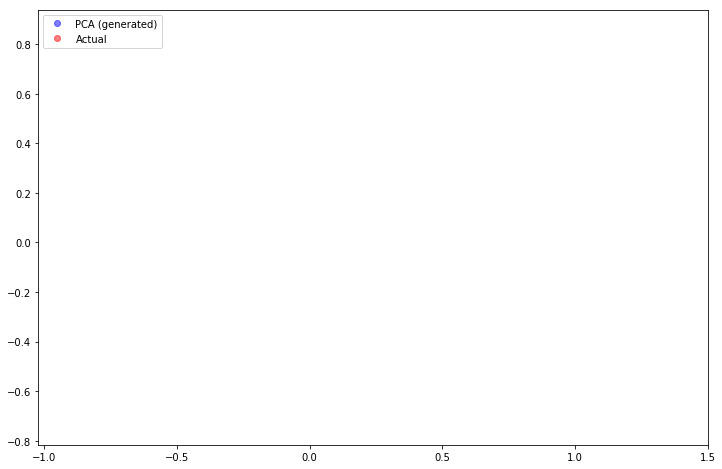

In [17]:
#create animation
fig,plots,legends = frameSetup()
anim = FuncAnimation(fig, animate, init_func=init, frames=1000, interval=30)

In [18]:
#animate
HTML(anim.to_html5_video())

## Evaluate on Korean Language Video

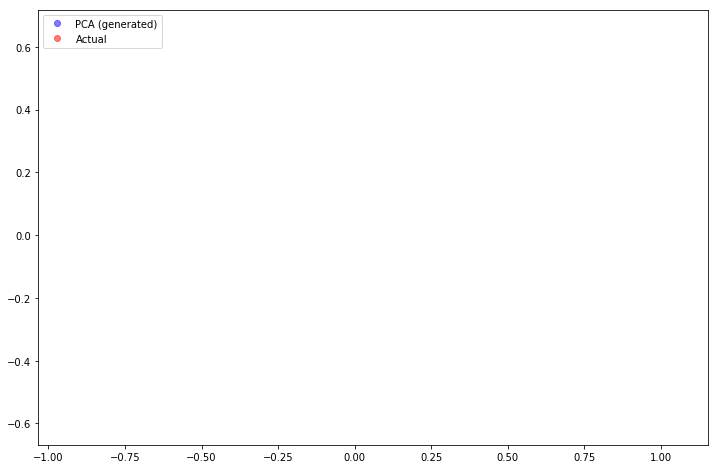

In [19]:
n,d,X,Y = loadData("Korean/pcaKorean1.txt","Korean/mouthKorean1.txt",transformationMatrix)
#Number of frames we use to make the animation
testNFrames = 36960
#create animation
fig,plots,legends = frameSetup()
anim = FuncAnimation(fig, animate, init_func=init, frames=1000, interval=30)
#animate
HTML(anim.to_html5_video())